---
format:
  html:
    code-line-numbers: true
    code-overflow: wrap
    code-block-bg: true
    code-block-border-left: true
    highlight-style: Arrow
---

# Job Shop Scheduling {#sec-ip-jsp}

In this section, we use Google OR-Tools to solve some of the classical integer programming problems.

To test the modeling of JSSP, we use a benchmarking instance from the OR-Library (@or-library), shown in the box below.
The two numbers in the first line represent the number of jobs and the number of machines, respectively.
Each remaining line contains the operations, processing machine and processing time, for each job.
Note that the machines are numbered starting from 0.

In [26]:
#| code-block-bg: true
#| code-block-border-left: "#31BAE9"

# Instance ft06 from OR-Library
# 6	6	
# 2	1	0	3	1	6	3	7	5	3	4	6
# 1	8	2	5	4	10	5	10	0	10	3	4
# 2	5	3	4	5	8	0	9	1	1	4	7
# 1	5	0	5	2	5	3	3	4	8	5	9
# 2	9	1	3	4	5	5	4	0	3	3	1
# 1	3	3	3	5	9	0	10	4	4	2	1

Suppose this instance data is saved in a file named *ft06.txt* and the code below defines an utility function to read and parse the instance for later use.

In [27]:
def read_jssp_instance(filename: str):
    with open(filename) as f:
        num_jobs, num_machines = [int(x) for x in next(f).split()]
        operations = []
        processing_times = {}
        job_idx = 0
        for line in f:
            info = [int(x) for x in line.split()]
            arr = [info[2 * m] for m in range(num_machines)]
            times = {info[2 * m]: info[2 * m + 1]
                    for m in range(num_machines)}
            operations.append(arr)
            processing_times[job_idx] = times
            job_idx += 1
    return num_jobs, num_machines, operations, processing_times

We present here three classical formulations of the JSSP from the literature and implement them using Google OR-Tools.

## Disjunctive model

This model is taken from @ku_mixed_2016 and @manne_job-shop_1960. 
The decision variables are defined as follows:

- $x_{ij}$: the processing starting time of job $j$ on machine $i$
- $z_{ijk}$: a binary variable that equals 1 if job $j$ precedes job $k$ on machine $i$

The disjunctive model can then be stated as below.

\begin{align}
    \text{min.} &\quad C_{max} \label{jsp-dis-obj}\\
    \text{s.t.} &\quad x_{ij} \geq 0, \ \forall j \in \mathcal{J}, i \in \mathcal{M} \label{jsp-dis-cons1}\\
    &\quad x_{o_h^j, j} \geq x_{o_{h-1}^j, j} + p_{o_{h-1}^j, j}, \ \forall j \in \mathcal{J}, h = 2, \cdots, m \label{jsp-dis-cons2}\\
    &\quad x_{ij} \geq x_{ik} + p_{ik} - V \cdot z_{ijk}, \ \forall i \in \mathcal{M}, j, k \in \mathcal{J}, j < k  \label{jsp-dis-cons3}\\
    &\quad x_{ik} \geq x_{ij} + p_{ij} - V \cdot (1 - z_{ijk}), \ \forall i \in \mathcal{M}, j, k \in \mathcal{J}, j < k  \label{jsp-dis-cons4}\\
    &\quad C_{max} \geq x_{o_m^j, j} + p_{o_m^j, j}, \ \forall j \in \mathcal{J}  \label{jsp-dis-cons5}\\
    &\quad z_{ijk} \in \{0, 1\}, \ \forall i \in \mathcal{M}, j, k \in \mathcal{J} \label{jsp-dis-cons6}
\end{align}

The objective \eqref{jsp-dis-obj} aims to minimize the maximal completion time of any job $j \in \mathcal{J}$.
Constraints \eqref{jsp-dis-cons1} require that all the job processing starting time must not be negative values.
Constraints \eqref{jsp-dis-cons2} enforce the sequencing order among operations for every job, which state that the $h$-th operation of job $j$, $o_h^j$, cannot start unless its preceeding operation $o_{h - 1}^j$ finishes.
Constraints \eqref{jsp-dis-cons3} and \eqref{jsp-dis-cons4} together make sure that at most one job can be processed on a machine at any time.
To be specific, in case of job $j$ preceding job $k$ on machine $i$, $z_{ijk}$ takes the value of 1 and constraints \eqref{jsp-dis-cons4} ensure that job $k$ won't start processing on machine $i$ unless job $i$ completes processing; Otherwise, $z_{ijk}$ takes the value of 0 and constraints \eqref{jsp-dis-cons3} require that job $j$ starts processing after job $k$.
Note that both constraints are needed when we require $j < k$; Otherwise, only one of them is needed if we create a constraint for every pair of $j$ and $k$ on a machine.
Constraints \eqref{jsp-dis-cons5} derive $C_{max}$ across all jobs.
The last constraints \eqref{jsp-dis-cons6} state the variable type of $z_{ijk}$.

The disjunctive formulation code is presented entirely in the following lines. The data related to the specific case are read between lines 5 to 8, and a solver object is created in line 11. The variable $x_{ij}$ is introduced in lines 16 to 23, followed by the introduction of variable $z_{ijk}$ in lines 25 to 34. The variable $C_{max}$ is defined in lines 36 to 38. The objective of the model is set in line 41, and the constraints are established in lines 44 to 80. The instance is solved, and the optimal solution is obtained from lines 82 to 93.


In [28]:
#| code-overflow: no-wrap
#| code-line-numbers: true

from typing import List, Dict
from ortools.linear_solver import pywraplp

# read and parse the data
filename = './data/jssp/ft06.txt'
num_jobs, num_machines, \
operations, processing_times = \
    read_jssp_instance(filename)

# create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create variables
infinity = solver.Infinity()
var_time: List[List] = []
for machine in range(num_machines):
    arr = [
        solver.NumVar(0, 
                    infinity, 
                    name=f'x_{machine, job}') 
        for job in range(num_jobs)
        ]
    var_time.append(arr)

var_prec: Dict = []
for machine in range(num_machines):
    mac_dict = {}
    for job_j in range(num_jobs - 1):
        for job_k in range(job_j + 1, num_jobs):
            mac_dict[(job_j, job_k)] = \
            solver.BoolVar(
                name=f'z_{machine, job_j, job_k}'
            )
    var_prec.append(mac_dict)

var_makespan = solver.NumVar(0, 
                            infinity, 
                            name='C_max')

# create objective
solver.Minimize(var_makespan)

# create constraints
for job, job_operations in enumerate(operations):
    for h in range(1, num_machines):
        curr_machine = job_operations[h]
        prev_machine = job_operations[h - 1]
        prev_time = processing_times[job][prev_machine]
        solver.Add(
            var_time[curr_machine][job] >= 
                var_time[prev_machine][job] + 
                prev_time
            )

V = 0
for job in processing_times:
    V += sum(processing_times[job].values())
for machine in range(num_machines):
    for job_j in range(num_jobs - 1):
        for job_k in range(job_j + 1, num_jobs):
            solver.Add(
                var_time[machine][job_j] >= 
                var_time[machine][job_k] +
                processing_times[job_k][machine] - 
                V * var_prec[machine][(job_j, job_k)]
            )
            solver.Add(
                var_time[machine][job_k] >= 
                var_time[machine][job_j] +
                processing_times[job_j][machine] - 
                V * (1 - var_prec[machine][(job_j, job_k)])
            )
            
for job in range(num_jobs):
    last_oper_machine = operations[job][-1]
    solver.Add(
        var_makespan >= 
        var_time[last_oper_machine][job] + 
        processing_times[job][last_oper_machine]
    )

status = solver.Solve()

if status == solver.OPTIMAL:
    print(f"min. makespan = {solver.Objective().Value():.2f}")
    
    opt_time = []
    for machine in range(num_machines):
        arr = [
            int(var_time[machine][job].solution_value()) 
            for job in range(num_jobs)
        ]
        opt_time.append(arr)

min. makespan = 55.00


The output of the model indicates that the lowest possible time needed to complete all tasks in this instance is 55. To illustrate the most efficient solution, we have created a function called `show_schedule()` that displays a Gantt chart of the tasks needed to process all jobs. @fig-jssp-dis-sol-ft06 displays the optimal solution for this instance.

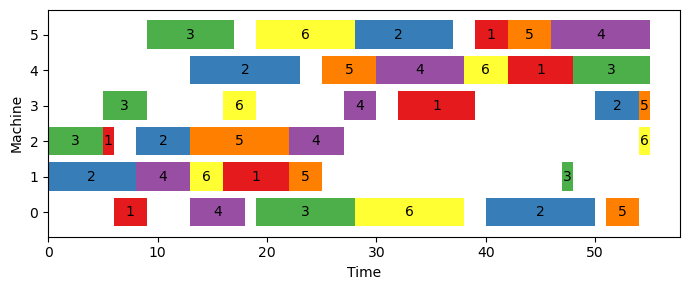

In [29]:
#| code-fold: false
#| label: fig-jssp-dis-sol-ft06
#| fig-cap: Optimal solution of the ft06 instance using the disjunctive formulation

import matplotlib as mpl
import matplotlib.pyplot as plt

def show_schedule(num_jobs, operations, processing_times, opt_time):
    colors = mpl.colormaps["Set1"].colors

    fig, ax = plt.subplots(figsize=[7, 3], dpi=100)

    for idx, job in enumerate(range(num_jobs)):
        machines = operations[job]
        job_start_times = [opt_time[machine][job] 
                            for machine in machines]
        job_processing_times = [processing_times[job][machine] 
                                for machine in operations[job]]
        
        if idx >= len(colors):
            idx = idx % len(colors)
        color = colors[idx]

        bars = ax.barh(machines, 
                width=job_processing_times, 
                left=job_start_times, 
                label=f'Job {job + 1}', 
                color=color)
        
        ax.bar_label(bars, 
                    fmt=f'{job + 1}', 
                    label_type='center')
        
    ax.set_yticks(machines)
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    fig.tight_layout()
    plt.show()
    
show_schedule(num_jobs, operations, processing_times, opt_time)

## Time-indexed model

The time-indexed formulation, proposed by @kondili_general_1988 and @ku_mixed_2016, involves the use of a binary variable $x_{ijt}$ that takes the value of 1 if job $j$ starts at time $t$ on machine $i$.
The model can be expressed as follows.

\begin{align}
\text{min.} &\quad C_{max} \label{jsp-time-obj}\\
\text{s.t.} &\quad \sum_{t \in H} x_{ijt} = 1, \ \forall j \in \mathcal{J}, i \in \mathcal{M} \label{jsp-time-cons1} \\
&\quad \sum_{t \in H} (t + p_{ij}) \cdot x_{ijt} \leq C_{max}, \ \forall j \in \mathcal{J}, i \in \mathcal{M} \label{jsp-time-cons2} \\
&\quad \sum_{j \in \mathcal{J}} \sum_{t' \in T_{ijt}} x_{ijt'} \leq 1, \ \forall i \in \mathcal{M}, t \in H, T_{ijt} = \{t - p_{ij} + 1, \cdots, t\} \label{jsp-time-cons3} \\
&\quad \sum_{t \in H} (t + p_{o_{h - 1}^j}, j) \cdot x_{o_{h - 1}^j, jt} \leq \sum_{t \in H} t \cdot x_{o_h^j, jt}, \ \forall j \in \mathcal{J}, h = 2, \cdots, m \label{jsp-time-cons4} \\
&\quad x_{ijt} \in \{0, 1\}, \ \forall j \in \mathcal{J}, i \in \mathcal{M}, t \in H \label{jsp-time-cons5}
\end{align}

In this formulation, the first set of constraints, referred to as \eqref{jsp-time-cons1}, state that each job $j$ must start at one specific time within the scheduling horizon $H$, which is determined as the sum of processing times for all jobs - $H = \sum_{i \in \mathcal{I}, j \in \mathcal{J}} p_{ij}$. Constraints \eqref{jsp-time-cons2} are used to calculate the value of $C_{max}$, while constraints \eqref{jsp-time-cons3} ensure that only one job can be processed by a machine at any given time. It's important to note that a job will remain on a machine for its full processing time and cannot be interrupted. Constraints \eqref{jsp-time-cons4} make sure that the order of processing jobs is followed, and constraints \eqref{jsp-time-cons5} define the variable types used in the formulation.

The following code provides a program that uses the time-indexed formulation to solve the `ft06` instance, with the value of $H$ being the sum of all job processing times plus one. 
The two variables, $x_{ijt}$ and $C_{max}$, are created in lines 18 - 27.
The constraints are created in lines 33 - 57.
The optimal solution is retrieved in lines 61 - 71.
It can be seen from the output that the same optimal objective, 55, is obtained using this formulation.

In [30]:
#| code-line-numbers: true

from typing import List, Dict
from ortools.linear_solver import pywraplp
import numpy as np

# read and parse the data
filename = './data/jssp/ft06.txt'
num_jobs, num_machines, \
operations, processing_times = \
    read_jssp_instance(filename)
    
# create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create variables
H = 1
for job in processing_times:
    H += sum(processing_times[job].values())
var_x = np.empty((num_machines, num_jobs, H), dtype=object)
for machine in range(num_machines):
    for job in range(num_jobs):
        for t in range(H):
            var_x[machine][job][t] = solver.BoolVar(name=f'x_{machine, job, t}')

infinity = solver.Infinity()
var_makespan = solver.NumVar(0, 
                            infinity, 
                            name='C_max')

# create objective
solver.Minimize(var_makespan)

# create constraints
for machine in range(num_machines):
    for job in range(num_jobs):
        solver.Add(solver.Sum([var_x[machine][job][t] for t in range(H)]) == 1)
        
for machine in range(num_machines):
    for job in range(num_jobs):
        arr = [var_x[machine][job][t] * (t + processing_times[job][machine]) for t in range(H)]
        solver.Add(solver.Sum(arr) <= var_makespan)
        
for machine in range(num_machines):
    for t in range(H):
        arr = [var_x[machine][job][tt]
                    for job in range(num_jobs)
                    for tt in range(t - processing_times[job][machine] + 1, t + 1)]
        solver.Add(solver.Sum(arr) <= 1)

for job in range(num_jobs):
    for oper in range(1, num_machines):
        prev_machine = operations[job][oper - 1]
        curr_machine = operations[job][oper]
        expr_prev = [(t + processing_times[job][prev_machine]) * var_x[prev_machine][job][t] 
                    for t in range(H)]
        expr_curr = [t * var_x[curr_machine][job][t]
                    for t in range(H)]
        solver.Add(solver.Sum(expr_prev) <= solver.Sum(expr_curr))

status = solver.Solve()

if status == solver.OPTIMAL:
    print(f"min. makespan = {solver.Objective().Value():.2f}")
    
    opt_time = []
    for machine in range(num_machines):
        arr = []
        for job in range(num_jobs):
            for t in range(t):
                if int(var_x[machine][job][t].solution_value()) == 1:
                    arr.append(t)
        opt_time.append(arr)

min. makespan = 55.00


The optimal solution can be seen in @fig-jssp-time-sol-ft06. Even though both formulations achieve the same optimal objective value, there are some minor discrepancies between the optimal solutions. For instance, in @fig-jssp-dis-sol-ft06, there is a gap after job 4 completes processing on machine 3, which is not present in @fig-jssp-time-sol-ft06.

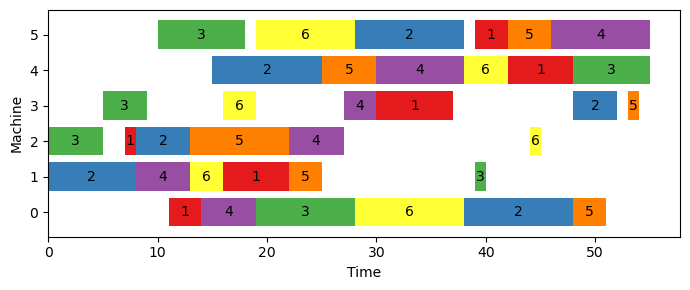

In [31]:
#| label: fig-jssp-time-sol-ft06
#| fig-cap: Optimal solution of the ft06 instance using the time-indexed formulation

show_schedule(num_jobs, operations, processing_times, opt_time)

## Rank-based model

The rank-based model is due to @wagner_integer_1959 and taken from @ku_mixed_2016.
There are three decision variables in this formulation:

- $x_{ijk}$: a binary variable that equals 1 if job $j$ is scheduled at the $k$-th position on machine $i$
- $h_{ik}$: a numerical variable that represents the start time of job at the $k$-th position of machine $i$.
- $C_{max}$: the makespan to be minimized

The complete model is given below.

\begin{align}
\text{min.} &\quad C_{max} \label{jsp-rank-obj} \\
\text{s.t.} &\quad \sum_{j \in \mathcal{J}} x_{ijk} = 1, \ \forall i \in \mathcal{M}, k = 1, \cdots, n \label{jsp-rank-cons1} \\
&\quad \sum_{k = 1}^n x_{ijk} = 1, \ \forall i \in \mathcal{M}, j \in \mathcal{J} \label{jsp-rank-cons2} \\
&\quad h_{ik} + \sum_{j \in \mathcal{J}} p_{ij} x_{ijk} \leq h_{i,k+1}, \ \forall i \in \mathcal{M}, k = 1, \cdots, n-1 \label{jsp-rank-cons3}\\
&\quad 
\begin{split}
    &\sum_{i \in \mathcal{M}} r_{ijl} h_{ik} + \sum_{i \in \mathcal{M}} r_{ijl}p_{ij} \leq V \cdot (1 - \sum_{i \in \mathcal{M}}r_{ijl}x_{ijk})\  +\  \\ 
    &V \cdot (1 - \sum_{i \in \mathcal{M}}r_{ij,l+1}x_{ijk'}) + \sum_{i \in \mathcal{M}}r_{ij,l+1}h_{ik'},\\ 
    &\forall j \in \mathcal{J}, k, k' = 1, \cdots, n, l = 1, \cdots, m - 1 
\end{split}
\label{jsp-rank-cons4}\\
&\quad h_{in} + \sum_{j \in \mathcal{J}} p_{ij}x_{ijk} \leq C_{max}, \ \forall i \in \mathcal{M} \label{jsp-rank-cons5}\\
&\quad h_{ik} \geq 0, \ \forall i \in \mathcal{M}, k = 1, \cdots, n \label{jsp-rank-cons6} \\
&\quad x_{ijk} \in \{0, 1\}, \ \forall j \in \mathcal{J}, i \in \mathcal{M}, k = 1, \cdots, n \label{jsp-rank-cons7}\\
&\quad C_{max} \geq 0 \label{jsp-rank-cons8}
\end{align}

In this formulation, constraints \eqref{jsp-rank-cons1} make sure that there is only one job assigned to a particular rank $k$ on machine $i$.
Constraints \eqref{jsp-rank-cons2} ensure that any job $j$ is assigned to one and only one rank on a machine $i$.
Constraints \eqref{jsp-rank-cons3} require that a machine can only process at most one job at any point of time.
Constraints \eqref{jsp-rank-cons4} guarantee that the processing order of a job is respected.
Constraints \eqref{jsp-rank-cons5} computes the makespan.
The remaining constraints \eqref{jsp-rank-cons6}, \eqref{jsp-rank-cons7} and \eqref{jsp-rank-cons8} indicate the variable types.

We now solve the same problem instance using this rank-based formulation in Google OR-Tools, for which the complete code is shown below.

In [32]:
#| code-line-numbers: true

from typing import List
from itertools import product
import numpy as np
from ortools.linear_solver import pywraplp

# read and parse the data
filename = './data/jssp/ft06.txt'
num_jobs, num_machines, \
operations, processing_times = \
    read_jssp_instance(filename)
    
# create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create variables
var_x = np.empty(shape=(num_machines, num_jobs, num_jobs), dtype=object)
for machine, job, rank in product(range(num_machines), 
                                range(num_jobs), 
                                range(num_jobs)):
    var_x[machine][job][rank] = solver.BoolVar(name=f'x_{machine, job, rank}')
            

infinity = solver.Infinity()
var_h = np.empty(shape=(num_machines, num_jobs), dtype=object)
for machine, rank in product(range(num_machines), range(num_jobs)):
    var_h[machine][rank] = solver.NumVar(0, infinity, name=f'h_{machine, rank}')

var_makespan = solver.NumVar(0, infinity, name=f'makesplan')

# create objective
solver.Minimize(var_makespan)

# create constraints
for machine, rank in product(range(num_machines), range(num_jobs)):
    expr = [var_x[machine][job][rank] for job in range(num_jobs)]
    solver.Add(solver.Sum(expr) == 1)

for machine, job in product(range(num_machines), range(num_jobs)):
    expr = [var_x[machine][job][rank] for rank in range(num_jobs)]
    solver.Add(solver.Sum(expr) == 1)

for machine, rank in product(range(num_machines), range(num_jobs - 1)):
    expr = [var_x[machine][job][rank] * processing_times[job][machine] 
            for job in range(num_jobs)]
    solver.Add(var_h[machine][rank] + solver.Sum(expr) <= var_h[machine][rank + 1])

r = np.zeros((num_machines, num_jobs, num_machines))
for job in range(num_jobs):
    job_operations: List = operations[job]
    for o_idx, o_machine in enumerate(job_operations):
        r[o_machine][job][o_idx] = 1
V = 0
for job in processing_times:
    V += sum(processing_times[job].values())

for job, k, kk, l in product(range(num_jobs), 
                            range(num_jobs), 
                            range(num_jobs), 
                            range(num_machines - 1)):
    expr_1 = [r[machine][job][l] * var_h[machine][k] 
            for machine in range(num_machines)]
    expr_2 = [r[machine][job][l] * processing_times[job][machine]
            for machine in range(num_machines)]
    expr_3 = [r[machine][job][l] * var_x[machine][job][k]
            for machine in range(num_machines)]
    expr_4 = [r[machine][job][l + 1] * var_x[machine][job][kk] 
            for machine in range(num_machines)]
    expr_5 = [r[machine][job][l + 1] * var_h[machine][kk] 
            for machine in range(num_machines)]
    solver.Add(solver.Sum(expr_1) + solver.Sum(expr_2) <= V * (1 - solver.Sum(expr_3)) + V * (1 - solver.Sum(expr_4)) + solver.Sum(expr_5))

for machine in range(num_machines):
    expr = [var_x[machine][job][num_jobs - 1] * processing_times[job][machine] for job in range(num_jobs)]
    solver.Add(var_h[machine][num_jobs - 1] + solver.Sum(expr) <= var_makespan)

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print(f"opt_obj = {solver.Objective().Value():.4f}")
    opt_time = []
    for machine in range(num_machines):
        arr = []
        for job in range(num_jobs):
            for rank in range(num_jobs):
                if int(var_x[machine][job][rank].solution_value()) == 1:
                    arr.append(var_h[machine][rank].solution_value())
        opt_time.append(arr)


opt_obj = 55.0000


@fig-jssp-rank-sol-ft06 displays the optimal solution obtained by utilizing the rank-based model. Upon careful examination, it is slightly distinct from the optimal solutions produced by the disjunctive model and the time-indexed model. Nevertheless, all three models achieve the same objective value of 55.

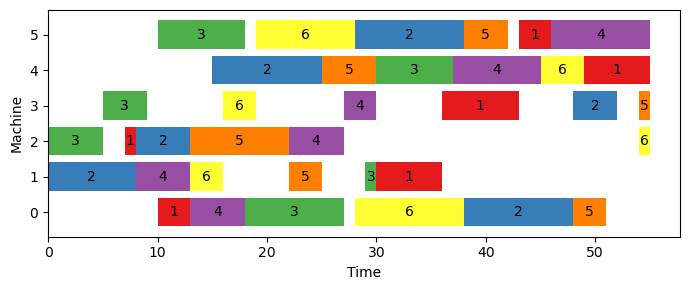

In [33]:
#| label: fig-jssp-rank-sol-ft06
#| fig-cap: Optional solution found by the rank-based model for instance ft06

show_schedule(num_jobs, operations, processing_times, opt_time)

While this book does not aim to compare the performance of the three modeling approaches, @tbl-jssp-data presents the computational times required by each formulation to discover the optimal solutions. The table indicates that the disjunctive model is the most efficient of the three, followed by the time-indexed model, while the rank-based model requires the longest time to converge. It should be noted that making a conclusion about the performance of these models based on one experimental run on a single instance is insufficient.

In [34]:
# | echo: false
# | label: tbl-jssp-data
# | tbl-cap: Computational time comparison of the three formulations

from IPython.display import Markdown
from tabulate import tabulate

row_names = ["ft06"]
col_names = ["Instance", "Disjunctive Model", "Time-indexed Model", "Rank-based Model"]

jsp_table_data = []
for idx, name in enumerate(row_names):
    if idx >= 3:
        break
    row_data = []
    # add row name
    row_data.append(name)
    
    # add consumption per activitiy/resource
    row_data.append('1.7s')
    row_data.append('1m34.9s')
    row_data.append('11m38.2s')
    
    jsp_table_data.append(row_data)

Markdown(tabulate(jsp_table_data, headers=col_names))

Instance    Disjunctive Model    Time-indexed Model    Rank-based Model
----------  -------------------  --------------------  ------------------
ft06        1.7s                 1m34.9s               11m38.2s